# Portfolio visualization in python 

In [125]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math

## Fetching data from yahoo financial

[*********************100%***********************]  3 of 3 completed
103.0999984741211


<AxesSubplot:xlabel='Date'>

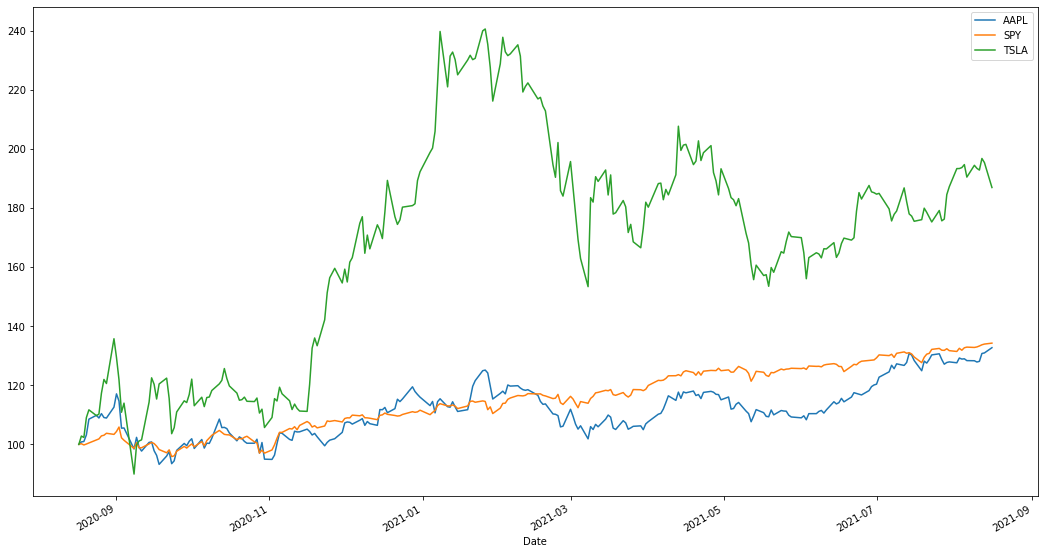

In [126]:
tickers = "SPY AAPL TSLA"

data = yf.download(tickers=tickers, period='1y')
print(min(data['Low']['AAPL']))
data['Low']['AAPL'].head()
adjclose = data['Adj Close']

#normalize the adjusted closes to see the relative performance of each stock 

normprice = adjclose/adjclose.iloc[0]*100

normprice.plot(figsize=(18,10))

(array([  1.,   0.,   2.,  18.,  78., 102.,  41.,   6.,   2.,   1.]),
 array([-0.21062826, -0.16992422, -0.12922019, -0.08851615, -0.04781211,
        -0.00710808,  0.03359596,  0.0743    ,  0.11500403,  0.15570807,
         0.19641211]),
 [<matplotlib.patches.Polygon at 0x7fdafee39430>])

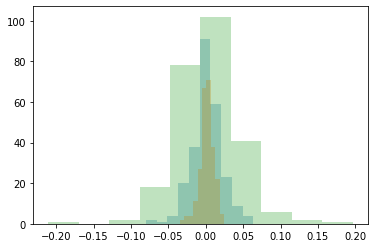

In [127]:
returns = adjclose/adjclose.shift(1) - 1

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=10)
plt.hist(returns['AAPL'], **kwargs)
plt.hist(returns['SPY'], **kwargs)
plt.hist(returns['TSLA'], **kwargs)

In [128]:
def ecdf(data):
    """Compute ECDF for a one dimensional arrary of measurements"""
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

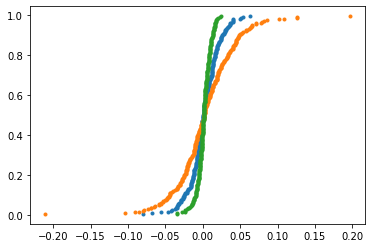

In [129]:
x, y = ecdf(returns['AAPL'])
plt.plot(x, y, marker='.', linestyle='none')

x, y = ecdf(returns['TSLA'])
plt.plot(x, y, marker='.',linestyle='none')

x, y = ecdf(returns['SPY'])
plt.plot(x, y, marker='.',linestyle='none')

plt.show()

In [130]:
adjclose.iloc[-1,:]/adjclose.iloc[0,:]-1

AAPL    0.327068
SPY     0.342450
TSLA    0.869021
dtype: float64

In [131]:
log_returns = np.log(adjclose/ adjclose.shift(1))

#To get the average annualized returns using 252 trading days
log_returns.mean() *252

AAPL    0.284100
SPY     0.295670
TSLA    0.627907
dtype: float64

In [132]:
returns.cov() * 252

,AAPL,SPY,TSLA
AAPL,0.101753,0.033153,0.102026
SPY,0.033153,0.021902,0.044141
TSLA,0.102026,0.044141,0.427640


## stock class

In [133]:
apple = yf.Ticker('AAPL')

In [134]:
apple.info['forwardPE']

26.652555

In [135]:
apple.info

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 147000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

## stock visualization

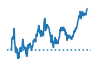

In [136]:
history = apple.history(period='1y')
close = history['Close']

#normalize the adjusted closes to see the relative performance of each stock 

normprice = close/close.iloc[0]

low = close.min()
high = close.max()
current = close.iloc[-1]




fig, ax = plt.subplots(figsize=(1.5,1))

ax.plot(normprice)
ax.axhline(y=1, ls='dotted')

plt.axis('off')
plt.show()

In [137]:
current

151.1199951171875

In [138]:
def get_bezier(p0, p1, p2, num=50):
    t = np.linspace(0,1,num).reshape((num,1))
    Bt = (1-t)**2*P0 + 2*(1-t)*t*P1 + t*t*P2
    return Bt[:,0], Bt[:,1]

In [139]:
def get_cpoints(vola1, vola2):
    """calcaulate the points of quadratic bezier curve based on the volatility of stock"""
    
    rv1 = (vola1-1)/10
    rv2 = (vola2-1)/10
    LIMIT = 4.8/10
    
    
    dx1 = min(rv1, LIMIT)
    dx2 = min(rv2, LIMIT)
    
    dy = lambda x: 0 if (x < LIMIT) else min(1/(4/LIMIT)*(x-LIMIT), 1/4)
    dy1 = dy(rv1)
    dy2 = dy(rv2)
        
    w = (dx1+dx2)/2
    
    return w, dx1, dy1, dx2, dy2
        
    

In [140]:
def pillarplot(ax, performance, vola1, vola2, low, high, current, width=1, height=1):
    
    
    
    dw, dx1, dy1, dx2, dy2 = get_cpoints(vola1, vola2)
    
    bottom_left = np.array([0,0]) 
    bottom_right = np.array([width,0])
    top_left = bottom_left + [0, height*performance]
    top_right = bottom_right + [0, height*performance]
    
    
    
    
    c1_left = (bottom_left*3/4 + top_left/4) + [width*dx1,0] -[0, dy1]
    c1_right = (bottom_right*3/4 + top_right/4) - [width*dx1,0] -[0, dy1]
    
    waist_left = (bottom_left + top_left)/2 + [width*dw,0] 
    waist_right = (bottom_right + top_right)/2 - [width*dw,0]
    
    
    c2_left = (bottom_left/4 + top_left*3/4) + [width*dx2, 0] + [0,dy2]
    c2_right = (bottom_right/4 + top_right*3/4) - [width*dx2, 0] + [0,dy2]

    top_left = bottom_left + [0, height] + [0, performance]
    top_right = bottom_right + [0, height] + [0, performance]
    
    
    Path = mpath.Path
    
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3,Path.CURVE3, Path.LINETO, Path.CURVE3,Path.CURVE3,Path.CURVE3,Path.CURVE3, Path.CLOSEPOLY]
    vertices = [bottom_left, c1_left, waist_left, c2_left, top_left, top_right, c2_right, waist_right, c1_right, bottom_right, bottom_left]

    pp = mpatches.PathPatch(Path(vertices, codes), facecolor='g', edgecolor='g', alpha=0.5)

    ax.add_patch(pp)
    pos = (current-low)/(high-low)*width
    ax.scatter(pos,0, facecolors='w', edgecolors='g', s=10)

    ax.axis('off')
    ax.set_xlim([-0.25,1.25])
    ax.set_ylim([-0.1,4.4])
    ax.set_aspect('equal', 'box')
    
    return
    

In [141]:
def visualize_stocks_subplot(tickers, period= '1y', benchmark='SPY', verbose=False):
    """visualize stock based on the historical data"""
    
    m_close = yf.download(tickers=benchmark, period=period)['Adj Close']
    m_perf = m_close.iloc[-1]/m_close.iloc[0]
    m_returns = np.log(m_close/ m_close.shift(1))
    m_vola = m_returns.std()
    
    data = yf.download(tickers=tickers, period=period)
    close = data['Adj Close']
    low = data['Low']
    high = data['High']
    
    ticker_list = tickers.split(" ")
    l = len(ticker_list)

    cols=10
    rows = math.ceil(l/cols)
    
    fig, axs = plt.subplots(rows, cols, sharey='row', figsize=(cols+2, 2*rows))
    
    
    for i, ticker in enumerate(ticker_list):        
        if (i%clos == 0):
            height = 1
            
            fig, axs = plt.subplots(1, cols, sharey='row', figsize=(cols+2,height))
        
        
        
        s_close = close[ticker]
        perf = s_close.iloc[-1]/s_close.iloc[0]
        returns = np.log(s_close/ s_close.shift(1))
        half = int(len(returns)/2)
        s_vola1 = returns.iloc[:half].std()
        s_vola2 = returns.iloc[half:].std()
        vola1 = s_vola1/m_vola
        vola2 = s_vola2/m_vola
        
        l = min(low[ticker]) 
        h = max(high[ticker])
        c = s_close[-1]
            
        pillarplot(ax, perf, vola1, vola2, l, h, c) 
        axs[i%cols].set_title(ticker)
        axs[i%cols].plot([0.5,0.5], [1, height], 'r.')

    fig.savefig("stocks.svg", format="svg")



In [270]:
from IPython.display import HTML
import io
import base64

class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        text-align-last: center;
        margin: 10px;
        border: 1px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes, ticker):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            ticker+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))


In [143]:
def visualize_stocks(tickers, period= '1y', benchmark='SPY', verbose=False):
    """visualize stock based on the historical data"""
    
    m_close = yf.download(tickers=benchmark, period=period)['Adj Close']
    m_perf = m_close.iloc[-1]/m_close.iloc[0]
    m_returns = np.log(m_close/ m_close.shift(1))
    m_vola = m_returns.std()
    
    data = yf.download(tickers=tickers, period=period)
    close = data['Adj Close']
    low = data['Low']
    high = data['High']

    
    ticker_list = tickers.split(" ")
    l = len(ticker_list)

    
    oPlot = FlowLayout() # create an empty FlowLayout

    for ticker in ticker_list:       
        #to do : exception process when ticker doesn't exist
        
        s_close = close[ticker].dropna()
        s_low = low[ticker].dropna()
        s_high = high[ticker].dropna()
        
        perf = s_close.iloc[-1]/s_close.iloc[0]
        returns = np.log(s_close/ s_close.shift(1))
        half = int(len(returns)/2)
        s_vola1 = returns.iloc[:half].std()
        s_vola2 = returns.iloc[half:].std()
        vola1 = s_vola1/m_vola
        vola2 = s_vola2/m_vola
        
        lo = min(s_low) 
        hi = max(s_high)
        cu = s_close[-1]

        height =  math.ceil(perf/m_perf)
        fig, ax = plt.subplots(figsize=(1,3))            
        pillarplot(ax, perf, vola1, vola2, lo, hi, cu) 
        ax.set_title(ticker)
        #ticks = np.arange(1, height+1)
        #xs = np.full(height, fill_value = 0.5)
        #plt.scatter(xs, ticks, c='r', s=1.8)
        fig.savefig("stocklookbookapp/static/stocks/"+ticker+"_"+period+".svg", format="svg")
        oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
        plt.close() # this gets rid of the plot so it doesn't appear in the cell


    oPlot.PassHtmlToCell()

In [76]:
SP10 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM"
SP23 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM JNJ V UNH PYPL HD PG MA DIS ADBE BAC CMCSA XOM"
SP30 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM JNJ V UNH PYPL HD PG MA DIS ADBE BAC CMCSA XOM PFE CRM CSCO VZ NFLX KO PEP INTC ABT NKE ABBV TMO ACN T MRK LLY CVX WMT AVGO WFC COST"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  43 of 43 completed



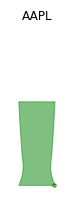
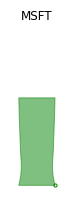
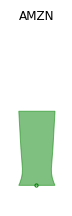
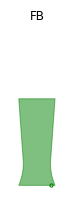
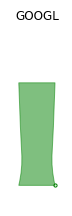
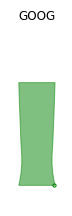
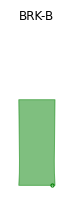
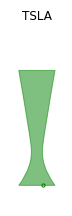
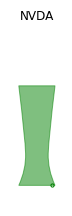
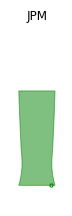
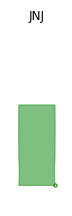
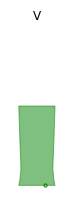
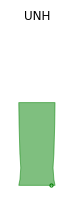
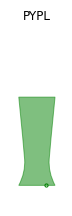
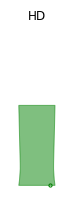
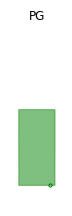
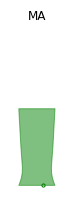
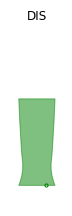
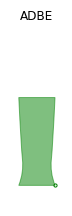
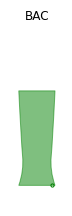
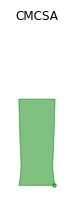
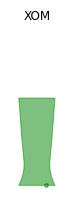
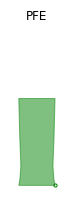
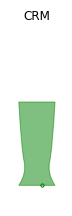
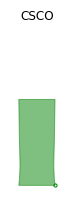
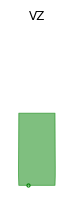
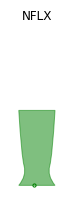
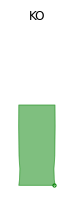
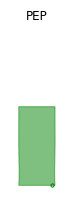
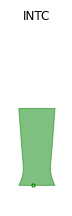
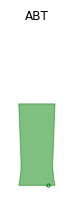
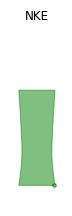
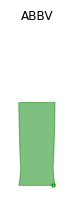
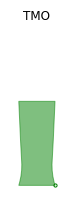
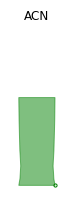
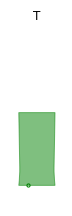
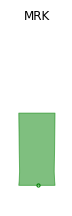
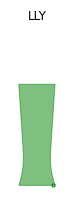
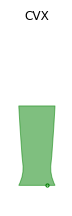
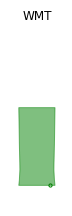
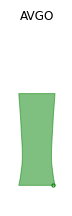
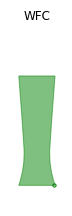
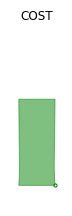

In [77]:
visualize_stocks(SP30,'1y')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  43 of 43 completed



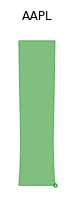
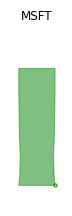
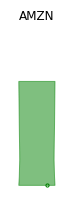
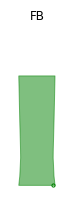
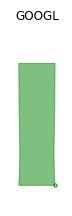
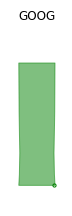
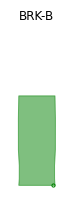
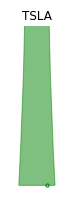
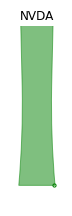
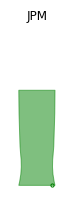
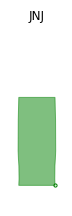
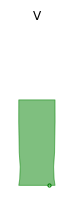
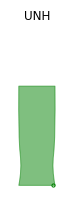
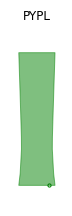
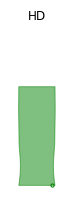
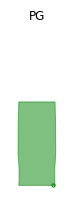
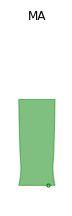
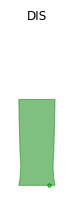
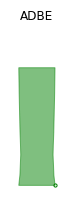
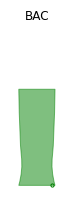
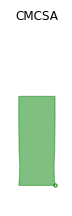
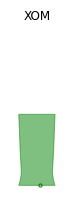
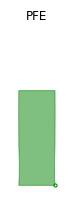
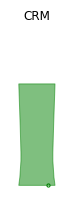
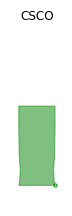
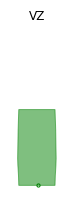
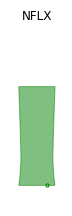
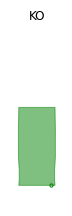
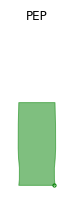
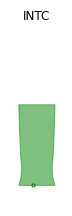
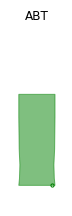
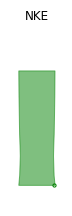
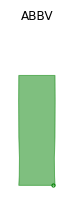
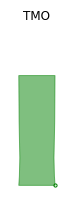
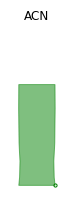
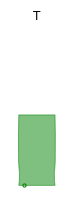
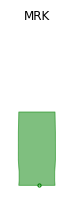
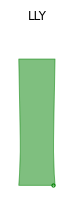
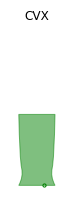
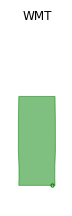
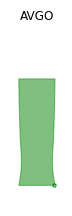
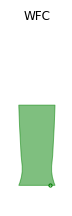
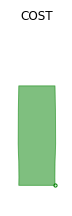

In [78]:
visualize_stocks(SP30,'2y')

In [79]:
tickers = "AMD TLRY PFE BA TDOC TEVA NAOV SPOT DUOL QS CAKE BTBT INFI AUPH SPRT U NEGG FB SNDL HMLP BB FLGC CLF GRVI GNRC BNTX WISH EVGO TLRY.TO MCD"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  30 of 30 completed



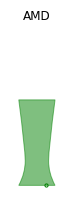
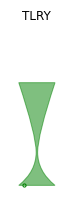
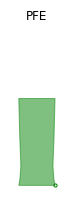
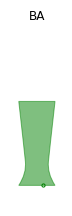
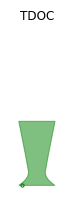
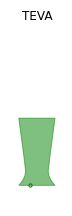
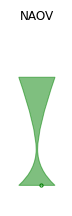
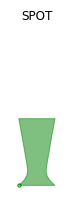
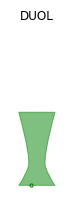
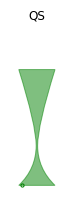
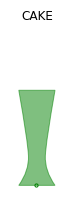
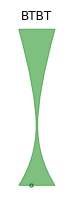
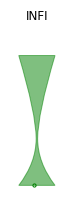
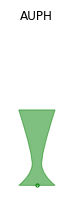
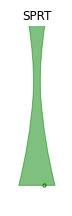
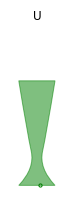
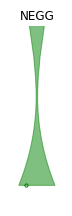
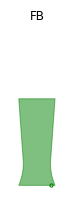
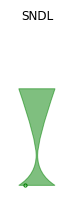
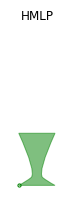
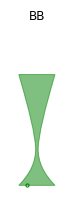
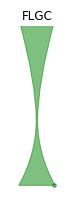
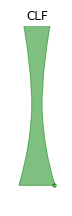
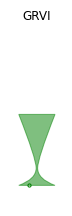
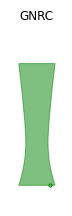
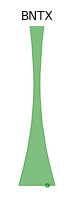
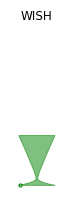
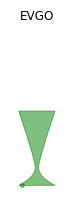
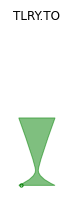
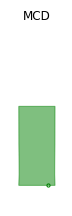

In [80]:
visualize_stocks(tickers,'1y')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  504 of 504 completed



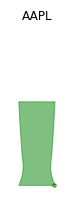
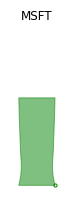
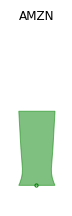
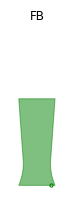
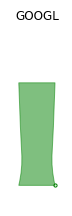
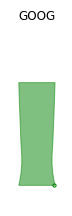
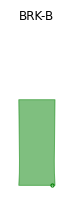
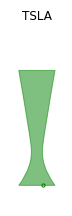
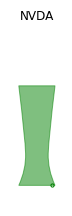
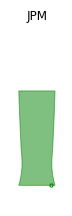
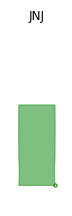
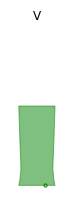
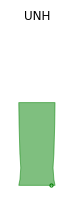
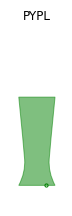
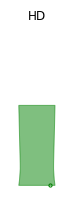
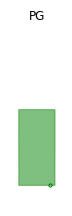
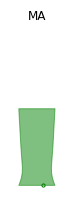
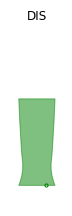
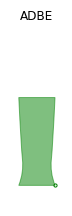
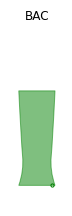
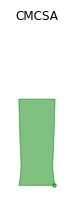
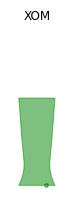
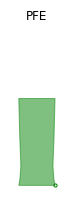
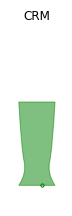
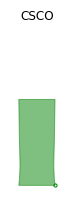
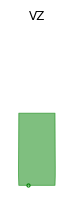
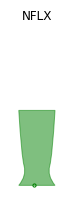
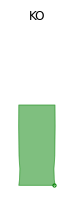
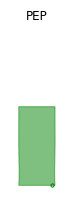
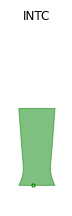
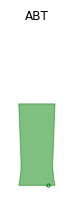
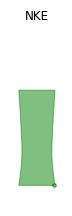
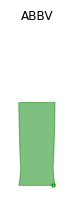
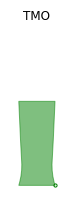
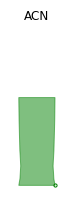
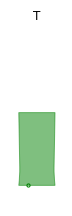
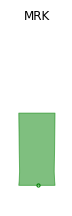
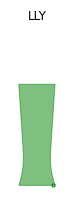
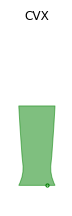
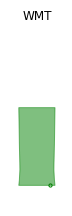
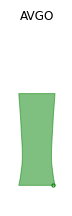
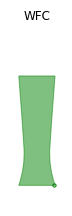
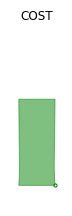
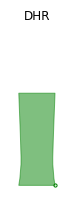
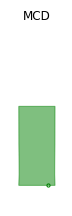
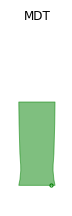
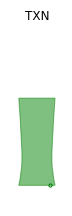
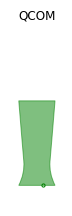
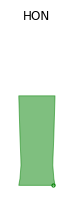
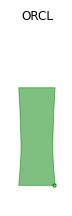
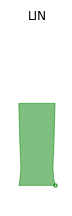
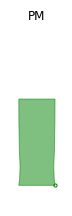
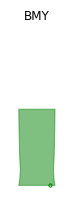
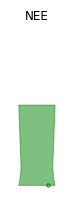
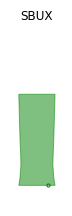
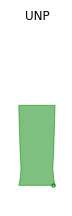
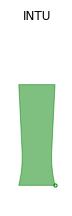
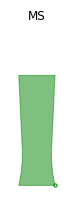
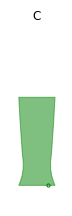
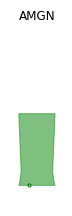
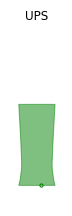
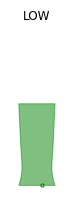
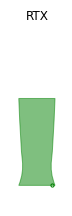
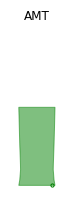
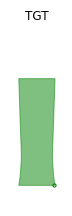
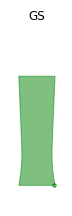
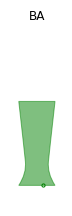
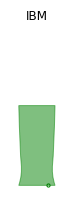
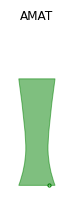
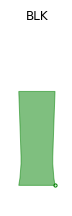
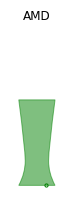
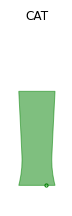
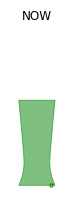
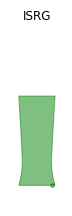
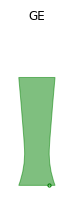
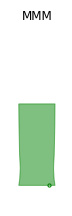
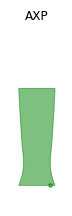
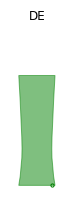
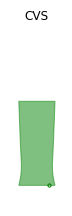
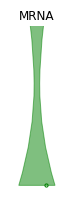
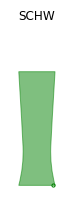
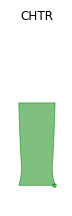
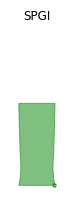
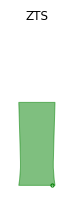
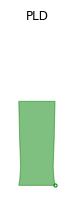
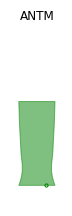
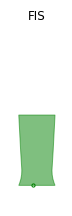
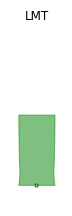
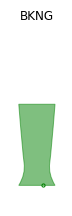
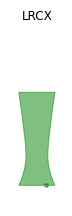
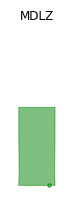
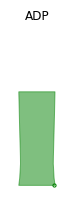
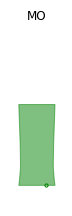
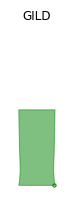
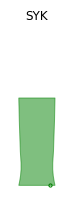
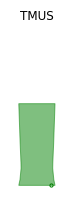
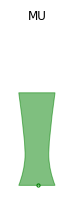
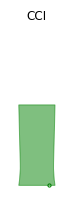
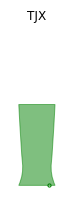
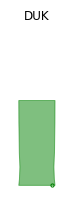
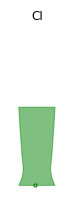
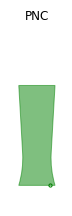
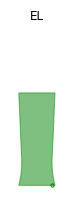
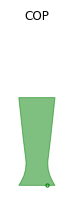
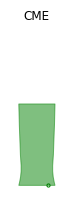
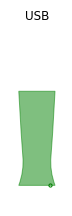
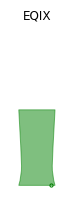
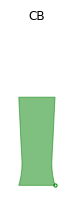
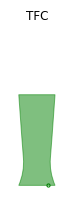
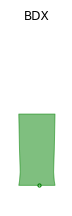
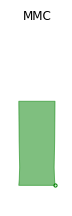
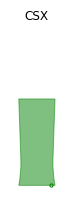
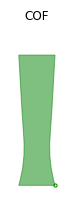
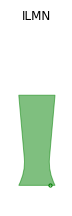
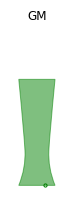
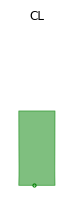
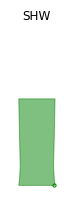
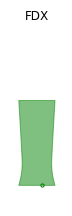
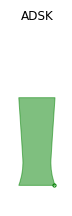
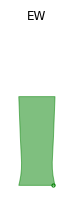
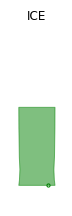
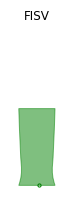
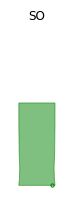
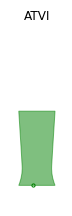
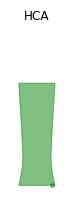
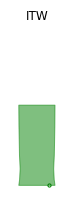
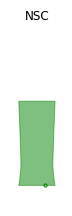
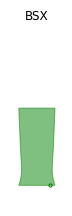
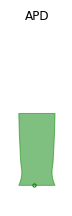
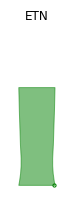
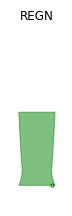
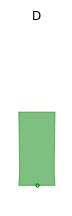
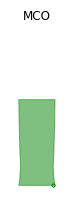
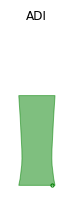
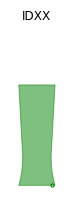
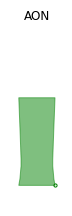
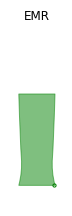
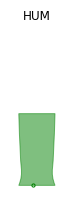
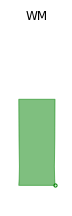
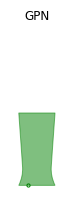
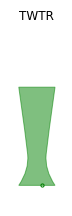
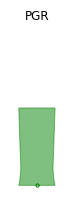
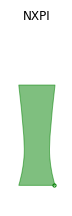
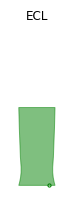
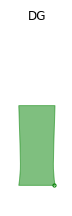
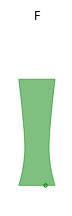
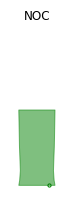
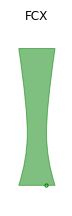
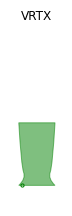
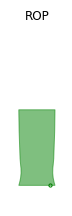
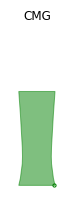
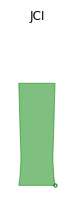
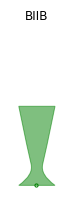
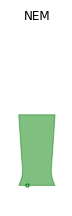
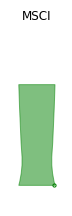
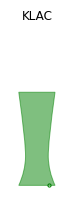
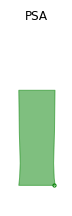
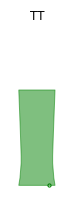
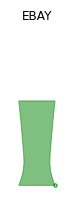
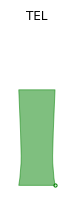
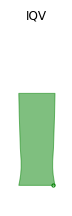
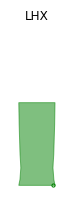
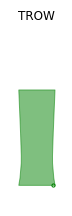
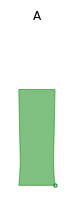
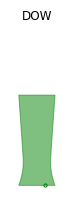
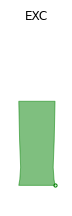
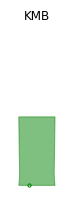
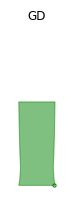
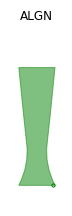
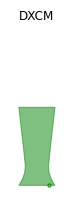
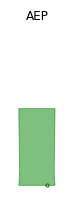
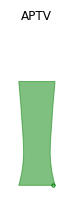
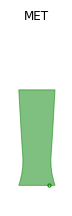
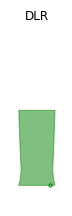
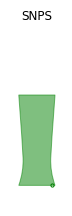
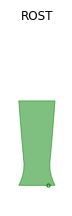
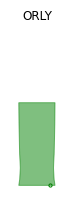
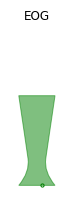
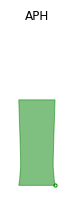
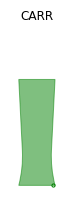
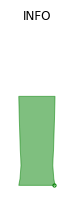
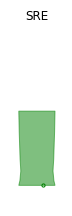
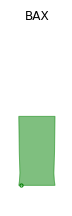
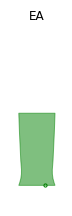
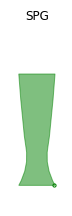
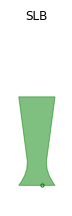
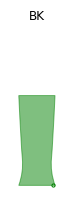
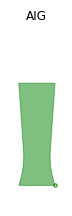
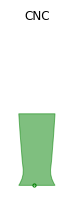
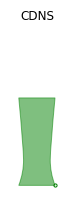
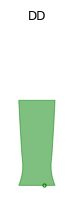
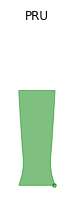
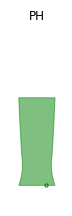
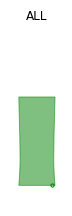
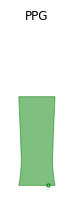
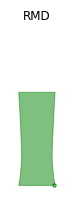
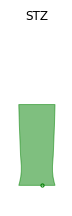
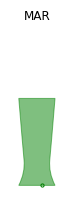
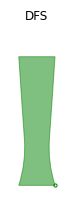
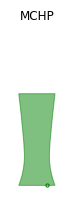
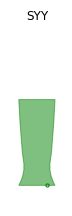
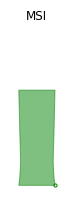
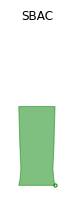
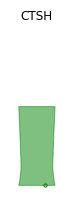
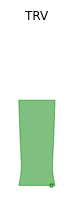
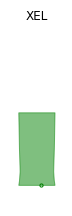
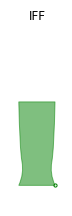
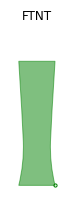
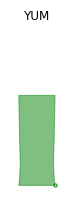
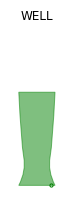
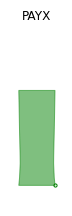
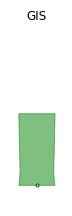
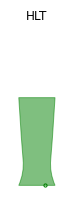
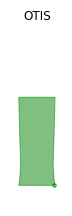
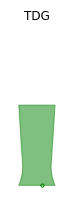
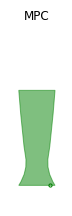
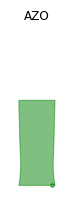
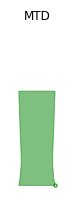
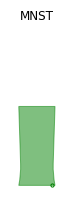
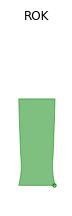
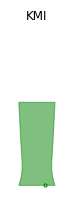
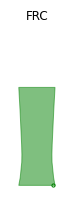
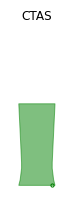
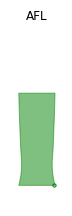
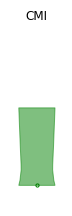
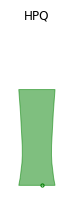
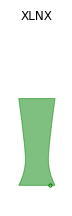
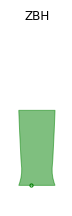
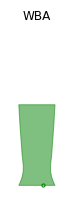
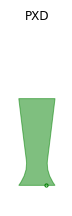
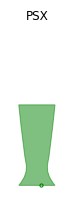
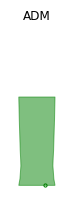
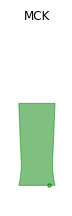
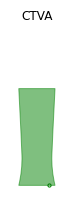
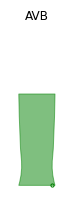
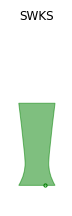
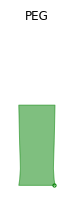
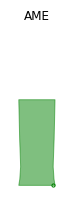
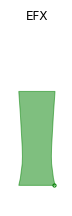
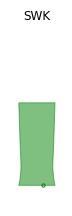
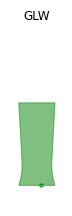
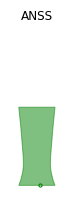
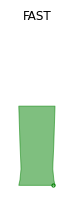
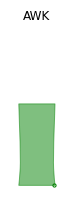
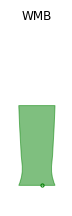
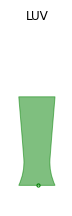
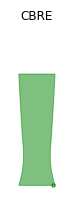
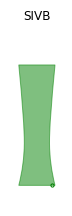
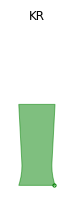
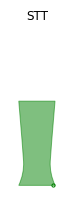
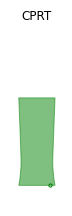
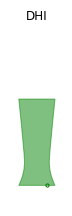
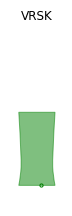
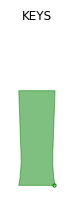
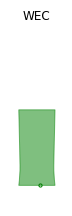
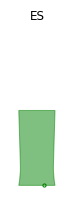
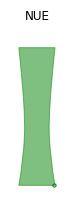
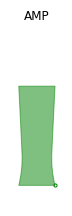
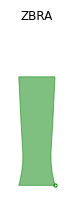
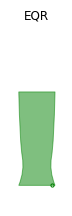
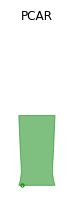
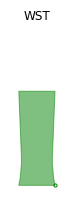
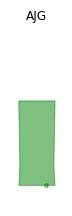
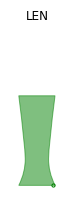
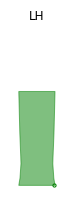
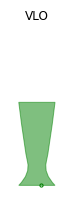
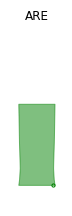
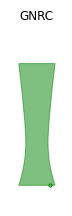
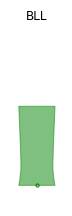
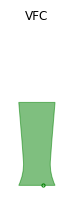
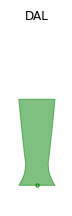
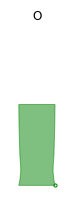
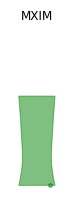
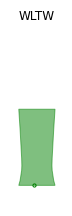
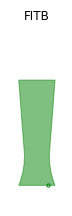
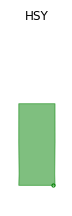
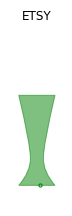
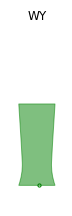
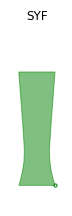
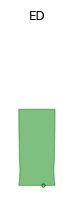
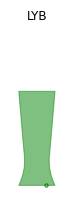
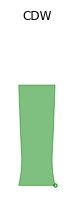
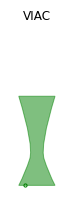
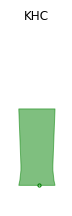
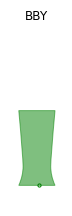
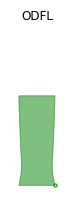
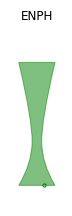
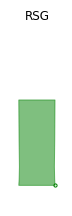
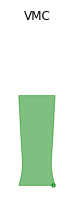
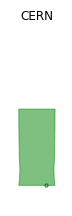
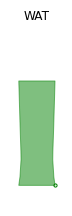
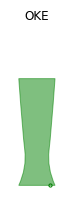
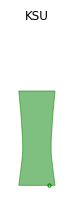
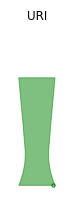
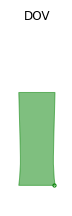
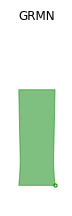
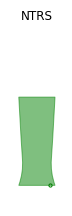
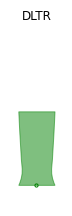
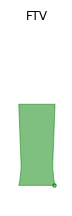
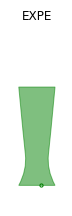
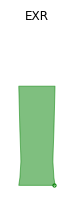
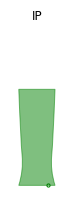
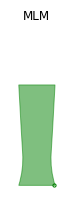
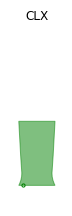
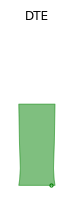
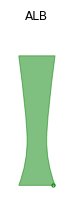
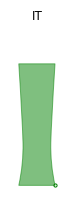
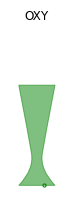
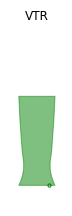
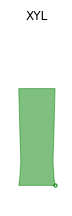
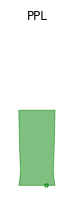
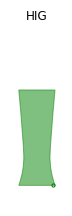
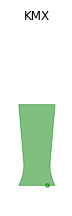
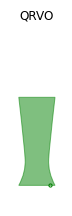
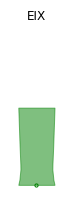
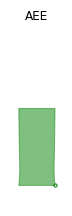
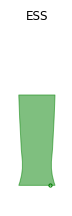
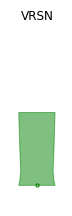
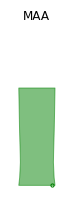
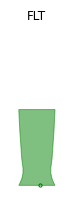
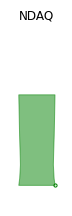
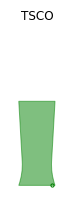
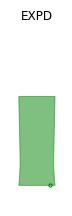
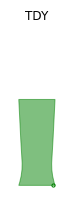
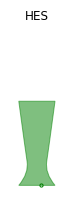
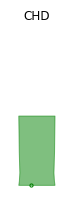
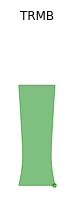
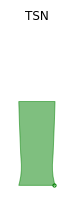
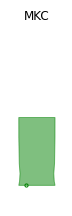
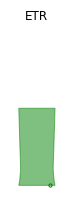
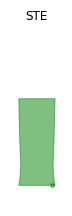
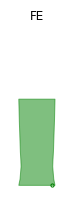
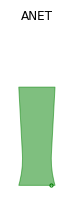
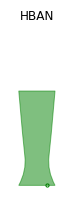
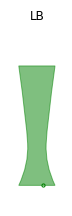
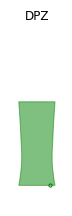
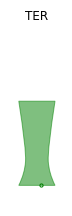
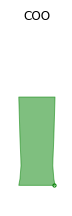
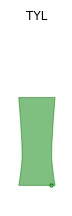
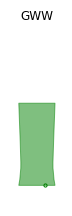
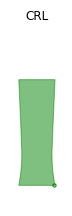
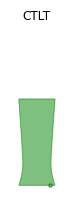
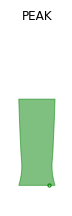
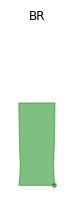
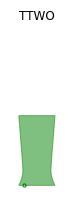
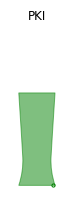
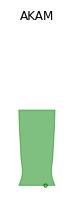
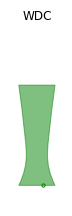
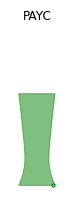
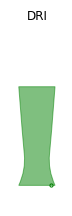
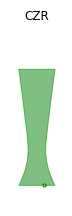
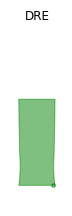
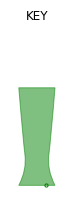
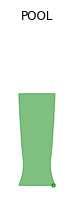
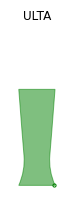
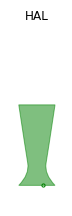
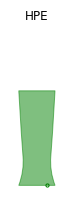
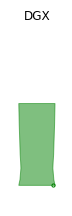
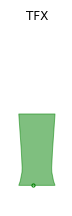
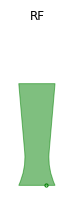
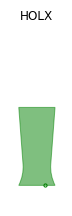
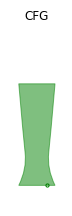
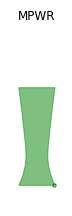
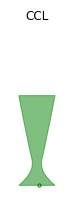
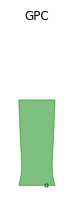
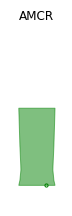
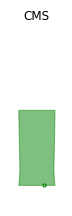
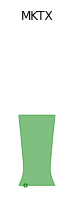
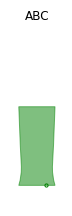
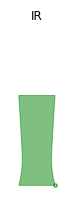
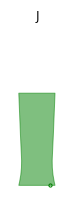
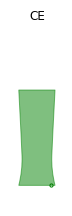
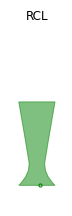
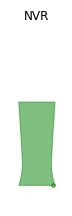
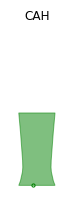
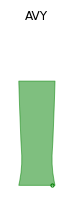
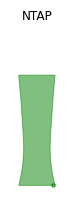
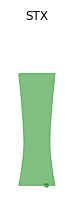
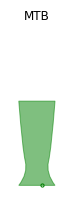
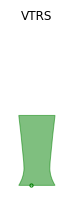
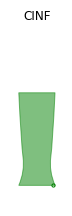
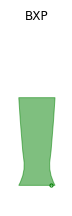
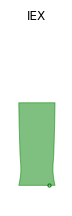
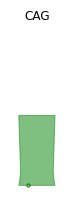
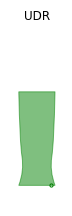
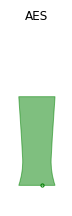
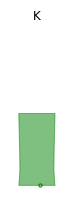
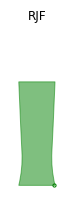
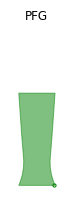
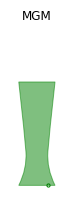
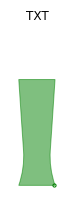
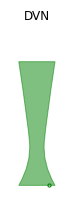
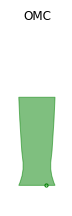
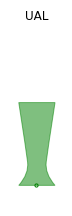
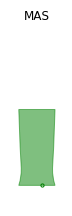
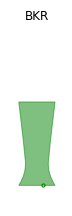
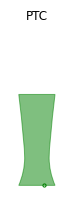
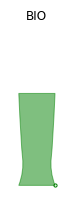
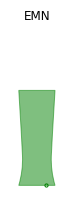
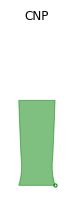
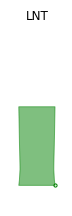
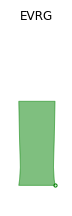
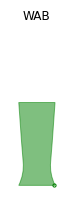
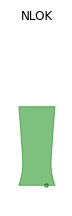
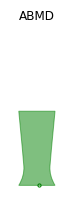
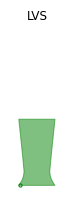
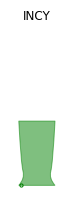
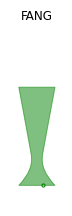
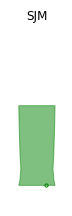
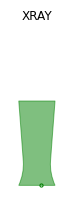
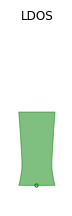
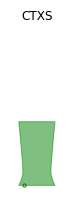
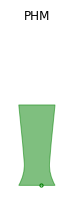
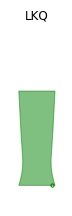
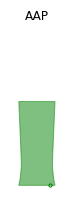
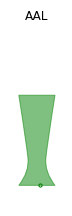
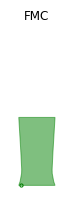
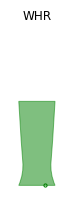
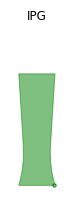
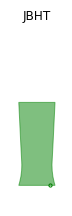
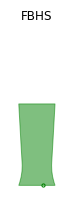
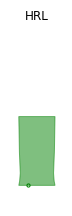
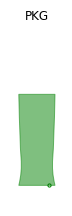
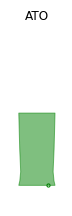
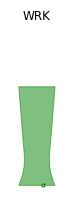
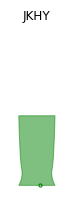
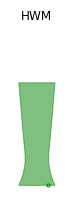
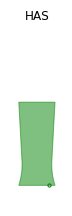
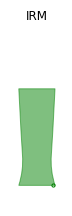
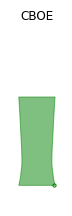
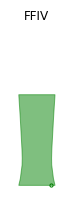
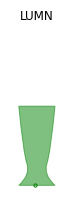
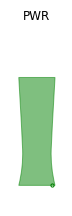
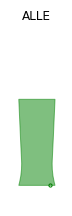
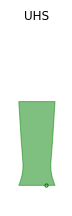
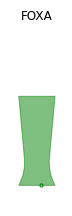
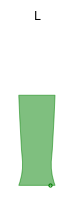
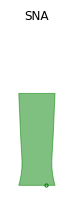
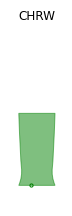
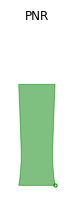
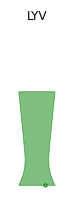
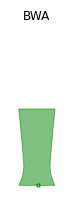
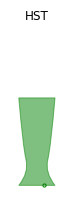
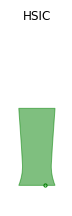
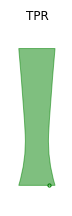
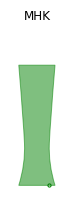
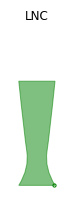
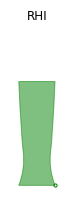
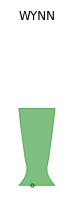
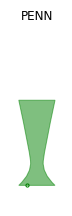
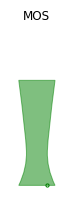
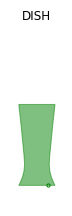
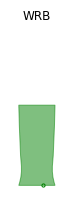
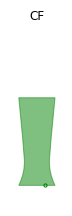
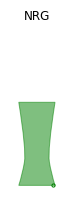
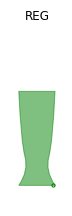
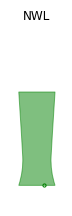
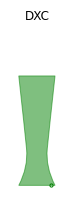
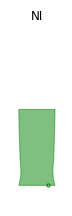
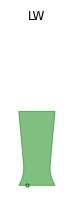
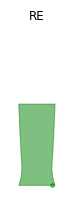
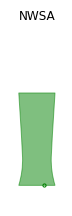
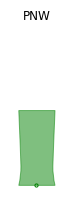
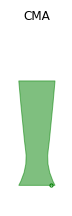
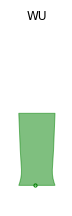
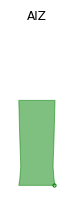
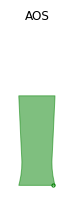
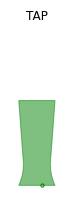
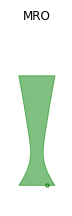
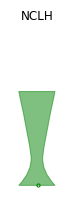
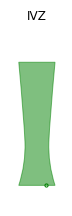
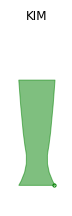
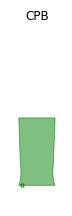
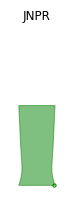
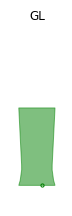
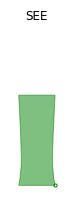
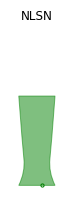
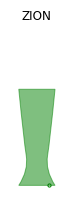
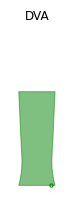
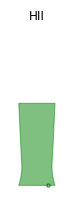
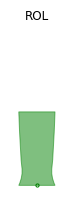
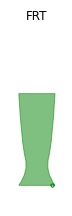
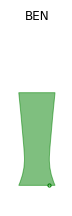
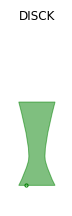
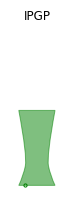
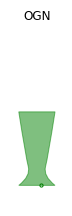
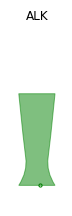
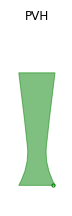
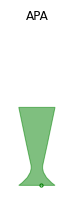
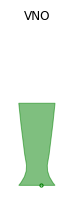
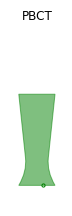
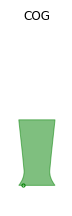
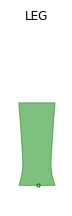
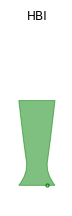
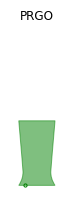
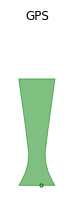
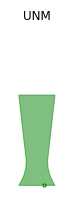
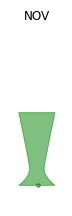
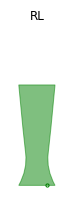
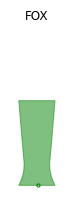
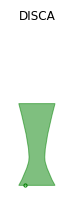
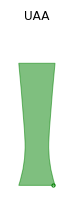
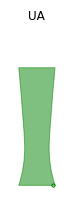
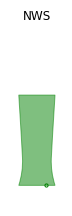

In [83]:
SP500 = "AAPL MSFT AMZN FB GOOGL GOOG BRK-B TSLA NVDA JPM JNJ V UNH PYPL HD PG MA DIS ADBE BAC CMCSA XOM PFE CRM CSCO VZ NFLX KO PEP INTC ABT NKE ABBV TMO ACN T MRK LLY CVX WMT AVGO WFC COST DHR MCD MDT TXN QCOM HON ORCL LIN PM BMY NEE SBUX UNP INTU MS C AMGN UPS LOW RTX AMT TGT GS BA IBM AMAT BLK AMD CAT NOW ISRG GE MMM AXP DE CVS MRNA SCHW CHTR SPGI ZTS PLD ANTM FIS LMT BKNG LRCX MDLZ ADP MO GILD SYK TMUS MU CCI TJX DUK CI PNC EL COP CME USB EQIX CB TFC BDX MMC CSX COF ILMN GM CL SHW FDX ADSK EW ICE FISV SO ATVI HCA ITW NSC BSX APD ETN REGN D MCO ADI IDXX AON EMR HUM WM GPN TWTR PGR NXPI ECL DG F NOC FCX VRTX ROP CMG JCI BIIB NEM MSCI KLAC PSA TT EBAY TEL IQV LHX TROW A DOW EXC KMB GD ALGN DXCM AEP APTV MET DLR SNPS ROST ORLY EOG APH CARR INFO SRE BAX EA SPG SLB BK AIG CNC CDNS DD PRU PH ALL PPG RMD STZ MAR DFS MCHP SYY MSI SBAC CTSH TRV XEL IFF FTNT YUM WELL PAYX GIS HLT OTIS TDG MPC AZO MTD MNST ROK KMI FRC CTAS AFL CMI HPQ XLNX ZBH WBA PXD PSX ADM MCK CTVA AVB SWKS PEG AME EFX SWK GLW ANSS FAST AWK WMB LUV CBRE SIVB KR STT CPRT DHI VRSK KEYS WEC ES NUE AMP ZBRA EQR PCAR WST AJG LEN LH VLO ARE GNRC BLL VFC DAL O MXIM WLTW FITB HSY ETSY WY SYF ED LYB CDW VIAC KHC BBY ODFL ENPH RSG VMC CERN WAT OKE KSU URI DOV GRMN NTRS DLTR FTV EXPE EXR IP MLM CLX DTE ALB IT OXY VTR XYL PPL HIG KMX QRVO EIX AEE ESS VRSN MAA FLT NDAQ TSCO EXPD TDY HES CHD TRMB TSN MKC ETR STE FE ANET HBAN LB DPZ TER COO TYL GWW CRL CTLT PEAK BR TTWO PKI AKAM WDC PAYC DRI CZR DRE KEY POOL ULTA HAL HPE DGX TFX RF HOLX CFG MPWR CCL GPC AMCR CMS MKTX ABC IR J CE RCL NVR CAH AVY NTAP STX MTB VTRS CINF BXP IEX CAG UDR AES K RJF PFG MGM TXT DVN OMC UAL MAS BKR PTC BIO EMN CNP LNT EVRG WAB NLOK ABMD LVS INCY FANG SJM XRAY LDOS CTXS PHM LKQ AAP AAL FMC WHR IPG JBHT FBHS HRL PKG ATO WRK JKHY HWM HAS IRM CBOE FFIV LUMN PWR ALLE UHS FOXA L SNA CHRW PNR LYV BWA HST HSIC TPR MHK LNC RHI WYNN PENN MOS DISH WRB CF NRG REG NWL DXC NI LW RE NWSA PNW CMA WU AIZ AOS TAP MRO NCLH IVZ KIM CPB JNPR GL SEE NLSN ZION DVA HII ROL FRT BEN DISCK IPGP OGN ALK PVH APA VNO PBCT COG LEG HBI PRGO GPS UNM NOV RL FOX DISCA UAA UA NWS"
visualize_stocks(SP500,'1y')

In [271]:
class Stocks:
    """ Stocks class for calculating stock stats and 
    visualizing a stock based on the stats.
    
    Attributes:
        tickers (list of str) a list of strings extracted from the tickers
        data (dataframe) representing the historical stock data
        info (nested dictionary) representing each stock's information
        stats (nested dictionary) representing each stock's stats 
            
    """
    import yfinance as yf
    
    def __init__(self, tickers, benchmark):
        self.tickers=tickers.split(" ")
        self.stats = {}
        self.m_stats = {}
        self.load_stocks(tickers, benchmark) 
        self.calculate_stats()
     #   self.load_info()
        
        
        
    
    def __repr__(self):
        """function to represent the instance of the stocks"""
        
        for stock, info in self.stats.items():
            print(stock)
            for key in info:
                print(key + ':', info[key])
        return "End of the stocks"
            
    def calculate_stats(self, period='1y'):
        """calcuate performance of each stock on given period and store it to dataframe"""
        
        m_close = self.market['Adj Close']
        m_returns = np.log(m_close/m_close.shift(1))
        self.m_stats[period] = {'performance': m_close.iloc[-1]/m_close.iloc[0], "volatility":m_returns.std()} 
        
        close = self.data['Adj Close']
        low = self.data['Low']
        high = self.data['High']
  
        for ticker in self.tickers:       
            #to do : exception process when ticker doesn't exist or only one ticker case
           
            s_close = close[ticker].dropna()
            s_low = low[ticker].dropna()
            s_high = high[ticker].dropna()
            if (len(s_close)>0):
                change = s_close.iloc[-1]/s_close.iloc[0]
                returns = np.log(s_close/ s_close.shift(1))
                half = int(len(returns)/2)
                vola1 = returns.iloc[:half].std()
                vola2 = returns.iloc[half:].std()

                self.stats[ticker] = {'performance':change, 
                                      'volatility1':vola1, 'volatility2':vola2, 
                                     "low":s_low.min(),"high":s_high.max(), "current":s_close.iloc[-1]}
         
            
            
        
    def load_stocks(self, tickers, benchmark, period='1y'):

        self.market = yf.download(tickers=benchmark, period=period)
        self.data = yf.download(tickers=tickers, period=period)   
    
    def visualize(self, period='1y'):
        oPlot = FlowLayout() # create an empty FlowLayout
        m_perf = self.m_stats[period]["performance"]
        m_vola = self.m_stats[period]["volatility"]
        for ticker, stats in self.stats.items():       
            
            
            #height =  math.ceil(stats["performance"]/self.m_stats[period]["performance"])
            fig, ax = plt.subplots(figsize=(1,3))            
            pillarplot(ax, stats["performance"]/m_perf, stats["volatility1"]/m_vola, stats["volatility2"]/m_vola, 
                       stats["low"], stats["high"], stats["current"]) 
            #ax.set_title(ticker)
            #ticks = np.arange(1, height+1)
            #xs = np.full(height, fill_value = 0.5)
            #plt.scatter(xs, ticks, c='r', s=1.8)
            fig.savefig("stocklookbookapp/static/stocks/"+ticker+"_"+period+".svg", format="svg")
            oPlot.add_plot(ax, ticker) # pass it to the FlowLayout to save as an image
            plt.close() # this gets rid of the plot so it doesn't appear in the cell


        oPlot.PassHtmlToCell()
        
    @staticmethod
    def get_cpoints(vola1, vola2):
        """calcaulate the points of quadratic bezier curve based on the volatility of stock"""

        rv1 = (vola1-1)/10
        rv2 = (vola2-1)/10
        LIMIT = 4.8/10


        dx1 = min(rv1, LIMIT)
        dx2 = min(rv2, LIMIT)

        dy = lambda x: 0 if (x < LIMIT) else min(1/(4/LIMIT)*(x-LIMIT), 1/4)
        dy1 = dy(rv1)
        dy2 = dy(rv2)

        w = (dx1+dx2)/2

        return w, dx1, dy1, dx2, dy2
    
    @staticmethod
    def pillarPlot(ax, performance, vola1, vola2, low, high, current, width=1, height=1):
    
        dw, dx1, dy1, dx2, dy2 = get_cpoints(vola1, vola2)

        bottom_left = np.array([0,0]) 
        bottom_right = np.array([width,0])
        top_left = bottom_left + [0, height*performance]
        top_right = bottom_right + [0, height*performance]


        c1_left = (bottom_left*3/4 + top_left/4) + [width*dx1,0] -[0, dy1]
        c1_right = (bottom_right*3/4 + top_right/4) - [width*dx1,0] -[0, dy1]

        waist_left = (bottom_left + top_left)/2 + [width*dw,0] 
        waist_right = (bottom_right + top_right)/2 - [width*dw,0]


        c2_left = (bottom_left/4 + top_left*3/4) + [width*dx2, 0] + [0,dy2]
        c2_right = (bottom_right/4 + top_right*3/4) - [width*dx2, 0] + [0,dy2]

        top_left = bottom_left + [0, height] + [0, performance]
        top_right = bottom_right + [0, height] + [0, performance]


        Path = mpath.Path

        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3,Path.CURVE3, Path.LINETO, Path.CURVE3,Path.CURVE3,Path.CURVE3,Path.CURVE3, Path.CLOSEPOLY]
        vertices = [bottom_left, c1_left, waist_left, c2_left, top_left, top_right, c2_right, waist_right, c1_right, bottom_right, bottom_left]

        pp = mpatches.PathPatch(Path(vertices, codes), facecolor='g', edgecolor='g', alpha=0.5)

        ax.add_patch(pp)
        pos = (current-low)/(high-low)*width
        ax.scatter(pos,0, facecolors='w', edgecolors='g', s=10)

        ax.axis('off')
        ax.set_xlim([-0.25,1.25])
        ax.set_ylim([-0.1,4.4])
        ax.set_aspect('equal', 'box')

        return
    

        
    
        
        
    #def addStocks():
        
    

In [272]:
mystocks = Stocks("AAPL AMD", "SPY")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


In [273]:
sp500

NameError: name 'sp500' is not defined

In [267]:
v_stocks = Stocks("AMD TLRY PFE BA TDOC TEVA NAOV SPOT DUOL QS CAKE BTBT INFI AUPH SPRT U NEGG FB SNDL HMLP BB FLGC CLF GRVI GNRC BNTX WISH EVGO TLRY.TO MCD", "SPY")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  30 of 30 completed



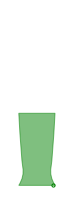
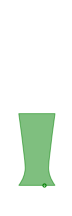

In [274]:
mystocks.visualize(period='1y')


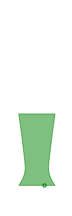
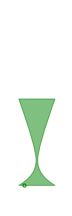
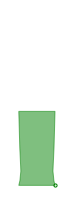
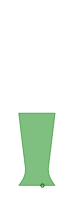
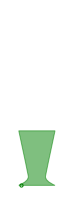
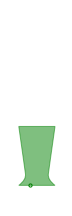
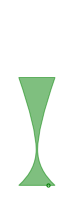
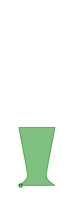
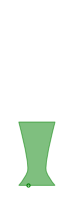
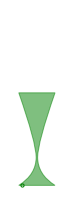
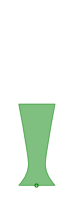
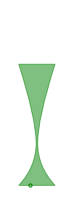
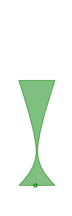
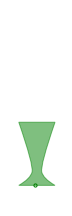
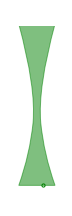
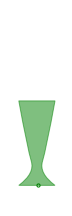
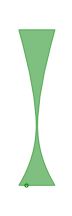
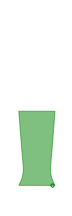
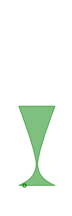
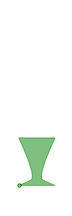
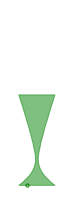
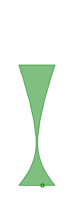
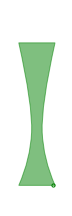
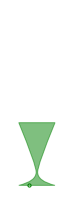
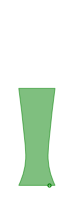
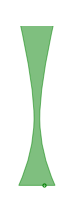
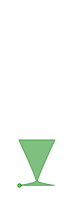
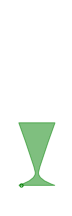
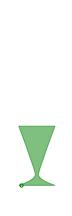
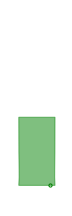

In [269]:
v_stocks.visualize()

The following single line of code generates a random array of weights that sum to 1.0. In the portfolio, one of the assumptions is that all funds will deployed to the assets in the portfolio according to some weighting.

# portfolio

In [ ]:
weights = np.random.dirichlet(np.ones(6), size=1)
weights = weights[0]
print(weights)

From these weights, we can calculate the expected weighted return of the portfolio of assets using these random weights.

In [ ]:
exp_port_return = np.sum(returns.mean()*weights)*252
print('portfolio mean: ',exp_port_return)

In [ ]:
np.dot(returns.cov()*252, weights)

In [ ]:
np.dot?

In [ ]:
port_var = np.dot(weights.T, np.dot(returns.cov()*252, weights))
port_vol = np.sqrt(port_var)
print(port_var)
print('portfolio volatility: ', port_vol)

In [ ]:
import time

def portfolio_simulation(assets, startdate, iterations):
    '''
    Runs a simulation by randomly selecting portfolio weights a specified
    number of times (iterations), returns the list of results and plots 
    all the portfolios as well.
    
    Parameters:
    -----------  
        assets: list
            all the assets that are to be pulled from Quandl to comprise
            our portfolio.    
        iterations: int 
            the number of randomly generated portfolios to build.
    
    Returns:
    --------
        port_returns: array
            array of all the simulated portfolio returns.
        port_vols: array
            array of all the simulated portfolio volatilities.
    '''
    
    start = time.time()
    num_assets = len(assets.split())
    
    data = yf.download(tickers=assets, start=startdate)
    acp = data['Adj Close']
    returns = np.log(acp/acp.shift(1))
    
    port_returns = []
    port_volats = []
    
    for i in range(iterations):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)
        weights = weights[0]
        port_returns.append(np.sum(returns.mean()*weights) * 252)
        port_volats.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))
        
    port_returns = np.array(port_returns)
    port_volats = np.array(port_volats)
    
    plt.figure(figsize=(18,10))
    plt.scatter(port_volats, port_returns, c=port_returns/port_volats, marker='o')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio')
    
    print('Elapsed Time: {} seconds'.format(time.time() - start))
    
    return port_returns, port_volats
    

    

In [ ]:
assets = "SPY AAPL MSFT QQQ VWO GLD"
startdate = "2015-01-01"

In [ ]:
portfolio_simulation(assets, startdate, 5000)

In [ ]:
def portfolio_stats(weights):
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, sharp ratio.
    '''
    
    # Convert to array in case list was passed instead.
    weights = np.array(weights)
    port_return = np.sum(returns.mean()*weights)*252
    port_volat = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
    sharpe = port_return/port_volat
    
    return {'return': port_return, 'volatility':port_volat, 'sharpe':sharpe}

## Minimization Functions


In [ ]:
def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

def minimize_volatility(weights):  
    # Note that we don't return the negative of volatility here because we 
    # want the absolute value of volatility to shrink, unlike sharpe.
    return portfolio_stats(weights)['volatility'] 

def minimize_return(weights): 
    return -portfolio_stats(weights)['return']

## The Optimization Function

The scipy.optimize function accepts several parameters in order to optimize on your desired variable. Some of these are especially important in the portfolio optimization process.

- constraints: In this case, our key constraint is that all the portfolio weights should sum to 1.0. What this means, practically, is that all of our cash should be invested in an asset or ETF.
- bounds: Bounds is going to refer to how much of our portfolio one asset can take up, from 0.0 to 1.0. 0.0 being a 0% position, and 1.0 being a 100% position (That stock or ETF is our only holding). Note that we can change this if we want so that we don’t take on too much concentration risk. Concentration risk is the loss of diversification benefits you can encouter if one stock or ETF takes up too much of your portfolio. In reality, you might want to set these bounds to (0, 0.2), which means a single stock can only take up a maximum of 20% of the portfolio.
- initializer: Initializer just sets the initial weights of the optimization algorithm so that it has a starting point. Here we’ll just set them so that each stock takes up an equal percentage of the portfolio.

In [ ]:
num_assets = 6
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(num_assets))
initializer = num_assets * [1./num_assets,]

print (initializer)
print (bounds)

In [ ]:
import scipy.optimize as optimize
optimal_sharpe=optimize.minimize(minimize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print(optimal_sharpe)

In [ ]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
list(zip(assets,list(optimal_sharpe_weights)))

In [ ]:
optimal_stats = portfolio_stats(optimal_sharpe_weights)
print(optimal_stats)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

In [ ]:
df = px.data.stocks(indexed=True) - 1
fig = px.area(df, facet_col="company", facet_col_wrap=3)
fig.show()

In [ ]:
# Using plotly.express
import plotly.express as px

fig = px.line(adjclose)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.line(df, x='Date', y='AAPL.High', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## references

https://kevinvecmanis.io/finance/optimization/2019/04/02/Algorithmic-Portfolio-Optimization.html